In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, calinski_harabasz_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


from scipy.stats import shapiro
from scipy.stats import wilcoxon

# Read data

In [2]:
fig_path = '../Figures/'

In [3]:
path = '../Dataset/Power Networks/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces/'
filename = '2013_agg_dates.csv'
df = pd.read_csv(path+filename)

In [4]:
path = '../Dataset/Power Networks/'
filename = 'Tariffs.xlsx'
tar = pd.read_excel(path+filename)

# Functions

In [5]:
# Create datetime objects from extracted date
def make_datetime(year, day, month, hour):
    dtstr = '{}-{}-{}'.format(year, int(month), int(day))
    adate = datetime.strptime(dtstr, '%Y-%m-%d')
    newdate = adate.replace(hour=int(hour), minute=0)
    return newdate

In [6]:
# Index the different tariffs
def convert_to_label(val):
    if val == 'std':
        out = 0
    else:
        out = 1
    return out

# Merge datasets

In [7]:
tar = tar.rename(columns = {'TariffDateTime':'DateTime'}) # rename
tar['DateTime'] = pd.to_datetime(tar['DateTime']) # convert to datetime
df['DateTime'] = pd.to_datetime(df['DateTime']) # convert to datetime
merged = pd.merge(df, tar, on = 'DateTime', how = 'inner') # merge based on datetime

# Aggregate to hourly and create a table with consumers vs consumption

In [8]:
cons= merged.groupby(['Tariff', 'LCLid', 'stdorToU', 'Acorn_grouped', 'Month', 'Day', 'Hour'])['kwh'].sum().reset_index() # convert to hourly
cons['DateTime'] = cons.apply(lambda row: make_datetime(int(2013), row['Day'], row['Month'], row['Hour']), axis = 1) # update dataframe with new datetimes
cons = cons.sort_values(by = 'DateTime') # making sure that everything is sorted

In [9]:
# Reshape for clustering
X = cons.groupby(['LCLid', 'stdorToU', 'Acorn_grouped', 'DateTime'])['kwh'].sum().unstack().reset_index()

In [10]:
date_cols = X.columns[3:] # keep only the features

In [11]:
cons

,Tariff,LCLid,stdorToU,Acorn_grouped,Month,Day,Hour,kwh,DateTime
4256784,Normal,MAC002077,Std,Adversity,1,1,0,0.316,2013-01-01 00:00:00
8092608,Normal,MAC004545,Std,Comfortable,1,1,0,0.141,2013-01-01 00:00:00
5568048,Normal,MAC002974,Std,Affluent,1,1,0,0.081,2013-01-01 00:00:00
9720384,Normal,MAC005457,Std,Affluent,1,1,0,0.172,2013-01-01 00:00:00
9818352,Normal,MAC005514,ToU,Comfortable,1,1,0,0.068,2013-01-01 00:00:00
5447472,Normal,MAC002899,Std,Adversity,1,1,0,0.065,2013-01-01 00:00:00
8167968,Normal,MAC004613,Std,Affluent,1,1,0,0.146,2013-01-01 00:00:00
6050352,Normal,MAC003273,Std,Affluent,1,1,0,1.995,2013-01-01 00:00:00
1800048,Normal,MAC000330,Std,Affluent,1,1,0,0.375,2013-01-01 00:00:00
3186672,Normal,MAC001382,Std,Comfortable,1,1,0,0.530,2013-01-01 00:00:00


# Boxplots for mean consumption

In [12]:
box_dat = cons.groupby(['Tariff', 'stdorToU', 'Month', 'Day', 'Hour'])['kwh'].mean().reset_index()

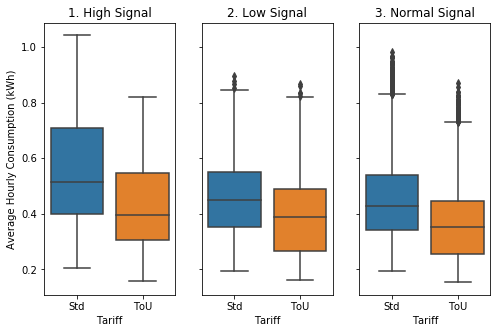

In [13]:
fig, axs = plt.subplots(ncols=3, sharey= True, figsize = (8, 5))

for i, sig_val in enumerate(box_dat['Tariff'].unique()):
    title_i = i+1
    # filter dataset
    sig_ = (box_dat['Tariff'] == sig_val)
    temp = box_dat.loc[sig_]
    sns.boxplot(x="stdorToU", y="kwh", data=temp, ax = axs[i]) # plot
    axs[i].set_title('{}. {} Signal'.format(title_i,sig_val))
    axs[i].set_xlabel('Tariff')
    if i == 0:
        axs[i].set_ylabel('Average Hourly Consumption (kWh)')
    else:
        axs[i].set_ylabel(' ')

plt.savefig(fig_path+'boxplots_signals.png')
plt.show()

# Silhouette curve for clustering

In [14]:
# Scale by instance of consumer
sc = MinMaxScaler() 
X_f = sc.fit_transform(X[date_cols].T) # Scale from 0 to 1
X_f = X_f.T

In [15]:
# Exploring different K
cal_list = []
sil_list = []
k_list = [i for i in range(2,10)]

for k_num in k_list:
    model = KMeans(n_clusters = k_num)
    cluster = model.fit(X_f)
    sil_list.append(silhouette_score(X_f, cluster.labels_))
    cal_list.append(calinski_harabasz_score(X_f, cluster.labels_))

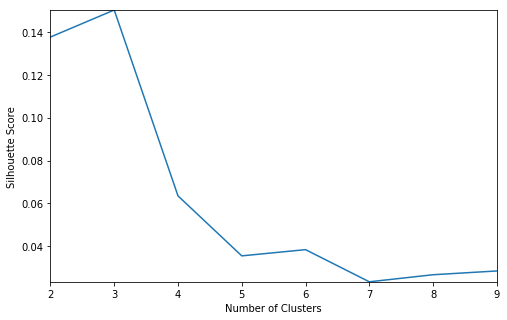

In [16]:
# Visualise the results
fig, ax = plt.subplots(figsize = (8, 5))

plt.plot(k_list, sil_list)

ax.margins(0)
ax.set_xticks(k_list)
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Number of Clusters')
# plt.savefig(fig_path+'Silhouette Score.png')
plt.show()

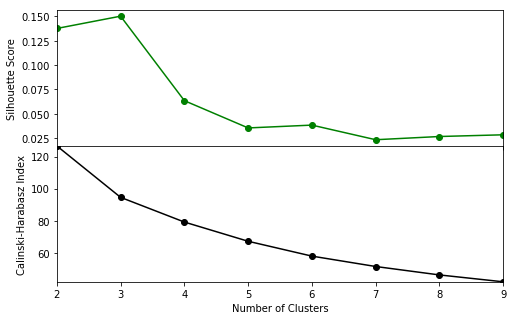

In [17]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (8, 5)) # 2 graphs with same xaxis

fig.subplots_adjust(hspace=0) # Remove horizontal space between axes

axs[0].plot(k_list, sil_list, color = 'green', marker = 'o')
# axs[0].margins(0)
axs[0].set_xticks(k_list)
axs[0].set_ylabel('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')

axs[1].plot(k_list, cal_list, color = 'black', marker = 'o')
axs[1].margins(0)
axs[1].set_xticks(k_list)
axs[1].set_ylabel('Calinski-Harabasz Index')
axs[1].set_xlabel('Number of Clusters')
# plt.savefig(fig_path+'Scores for clusters.png')

plt.show()

In [18]:
np.linspace(0, 10)

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

In [19]:
# free up some memory
del merged

# K-Means 

In [20]:
K = 3
kmeans = KMeans(n_clusters=K)
cluster = kmeans.fit_predict(X_f)
X['cluster'] = cluster

# PCA

In [21]:
pca = PCA()
reduced = pca.fit_transform(X_f)

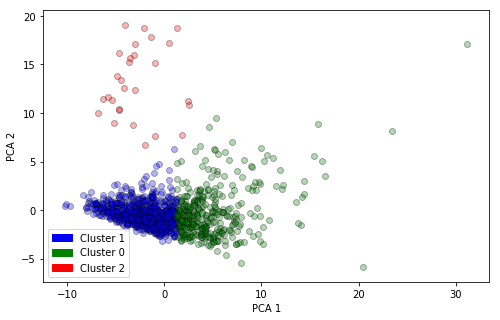

In [22]:
colors = ['blue', 'green', 'red']
col_dic = dict(zip(X['cluster'].unique(), colors))

fig, ax = plt.subplots(figsize = (8, 5))

for i in range(X.shape[0]):
    cluster_num = X['cluster'].loc[i]
    plt.scatter(reduced[i,0], reduced[i,1], color = col_dic[cluster_num], alpha = 0.3, edgecolor = 'black')
    
patchList = []
for key in col_dic:
        data_key = mpatches.Patch(color=col_dic[key], label='Cluster '+str(key))
        patchList.append(data_key)

plt.legend(handles=patchList)
ax.set_ylabel('PCA 2')
ax.set_xlabel('PCA 1')
plt.savefig(fig_path+'PCA_clustering.png')
plt.show()

In [23]:
X.groupby(['cluster', 'stdorToU']).size()
# X.groupby(['cluster', 'stdorToU'])['kwh']

cluster  stdorToU
0        Std         313
         ToU          56
1        Std         540
         ToU         195
2        Std          28
dtype: int64

# TSNE

In [24]:
tsne = TSNE(n_components = 2)
reduced = tsne.fit_transform(X_f)

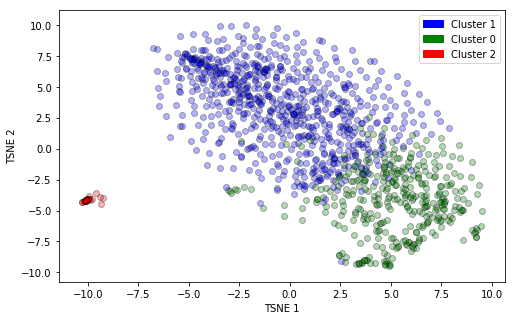

In [25]:
colors = ['blue', 'green', 'red']
col_dic = dict(zip(X['cluster'].unique(), colors))

fig, ax = plt.subplots(figsize = (8, 5))

for i in range(X.shape[0]):
    cluster_num = X['cluster'].loc[i]
    plt.scatter(reduced[i,0], reduced[i,1], color = col_dic[cluster_num], alpha = 0.3, edgecolor = 'black')
    
patchList = []
for key in col_dic:
        data_key = mpatches.Patch(color=col_dic[key], label='Cluster '+str(key))
        patchList.append(data_key)

plt.legend(handles=patchList)
ax.set_ylabel('TSNE 2')
ax.set_xlabel('TSNE 1')
plt.savefig(fig_path+'TSNE_clustering.png')
plt.show()

In [54]:
X

array([0, 1, 2])

# Normality Check Shapiro

In [26]:
cons = pd.merge(X[['LCLid', 'cluster']], cons, on = 'LCLid', how = 'inner') # get the ids and cluster names with merging

In [27]:
av = cons.groupby(['cluster', 'stdorToU', 'Tariff', 'DateTime'])['kwh'].mean().reset_index() # get mean conumption for each tariff type

In [28]:
av.head()

,cluster,stdorToU,Tariff,DateTime,kwh
0,0,Std,High,2013-01-07 23:00:00,0.829812
1,0,Std,High,2013-01-08 00:00:00,0.596035
2,0,Std,High,2013-01-08 01:00:00,0.466722
3,0,Std,High,2013-01-11 11:00:00,0.779990
4,0,Std,High,2013-01-11 12:00:00,0.737192


In [29]:
table = av.groupby(['cluster', 'stdorToU', 'Tariff'])['kwh'].apply(shapiro).reset_index() # apply shapiro test
table['Shapiro F'] = table['kwh'].apply(lambda row: float(str(row).strip('()').split(',')[0])) # convert tuples to floats
table['Shapiro P']= table['kwh'].apply(lambda row: float(str(row).strip('()').split(',')[1])) # convert tuples to floats

C:\Users\Thanasis\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [30]:
table['Shapiro P'] = table['Shapiro P'].round(3) #Round values
table['Shapiro F'] = table['Shapiro F'].round(3) #Round values
table.drop('kwh', axis =1, inplace = True)
table

,cluster,stdorToU,Tariff,Shapiro F,Shapiro P
0,0,Std,High,0.963,0.0
1,0,Std,Low,0.962,0.0
2,0,Std,Normal,0.950,0.0
3,0,ToU,High,0.971,0.0
4,0,ToU,Low,0.963,0.0
5,0,ToU,Normal,0.959,0.0
6,1,Std,High,0.977,0.0
7,1,Std,Low,0.954,0.0
8,1,Std,Normal,0.953,0.0
9,1,ToU,High,0.971,0.0


In [31]:
# writer = pd.ExcelWriter('../Tables/Shapiro_results.xlsx')
# table.to_excel(writer)
# writer.save()

# Hypothesis Testing

In [32]:
st_list = [] # list with statistic
p_list = [] # list with p values
cl_list = [] # list with clusters
t_list = [] # list with tariffs
for cl in av['cluster'].unique(): # for every cluster
    for signal in av['Tariff'].unique(): # for every signal
        f_cl = av['cluster'] == cl # filter cluster
        f_t = av['Tariff'] == signal # filter cluster
        x = av['kwh'].loc[(f_cl) & (f_t) & (av['stdorToU'] == 'Std')]
        y = av['kwh'].loc[(f_cl) & (f_t) & (av['stdorToU'] == 'ToU')]
        if len(y) == len(x):
            st_list.append(wilcoxon(x, y)[0]) # non parametric test
            p_list.append(wilcoxon(x, y)[1]) # non parametric test
            cl_list.append(cl)
            t_list.append(signal)

In [33]:
# Create and finalise dataframe
w_df = pd.DataFrame(dict({'Tariff': t_list, 'Cluster': cl_list, 'Statistic': st_list, 'P value': p_list}))
w_df['P value'] = w_df['P value'].round(3)
w_df = w_df.groupby(['Cluster', 'Tariff'])['Statistic', 'P value'].sum().unstack().reset_index()

In [34]:
# writer = pd.ExcelWriter('../Tables/Wilcoxon_results.xlsx')
# w_df.to_excel(writer)
# writer.save()

# Calculate and compare bills

In [35]:
# assign prices to signals
def assign_price(val):
    if val == 'High':
        out = 77.2
    elif val == 'Low':
        out = 3.99
    else:
        out = 11.76
    return out

In [36]:
av.head()

,cluster,stdorToU,Tariff,DateTime,kwh
0,0,Std,High,2013-01-07 23:00:00,0.829812
1,0,Std,High,2013-01-08 00:00:00,0.596035
2,0,Std,High,2013-01-08 01:00:00,0.466722
3,0,Std,High,2013-01-11 11:00:00,0.779990
4,0,Std,High,2013-01-11 12:00:00,0.737192


In [37]:
# Assign prices
av['SignalPrice'] = 14.23
av['SignalPrice'].loc[av['stdorToU'] == 'ToU'] = av['Tariff'].loc[av['stdorToU'] == 'ToU'].apply(assign_price)
av['SignalPrice'] = av['SignalPrice']/100 # from pences to pounds
av['Price'] = av['kwh']*av['SignalPrice'] # get the biils for every hour

C:\Users\Thanasis\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
av

,cluster,stdorToU,Tariff,DateTime,kwh,SignalPrice,Price
0,0,Std,High,2013-01-07 23:00:00,0.829812,0.1423,0.118082
1,0,Std,High,2013-01-08 00:00:00,0.596035,0.1423,0.084816
2,0,Std,High,2013-01-08 01:00:00,0.466722,0.1423,0.066415
3,0,Std,High,2013-01-11 11:00:00,0.779990,0.1423,0.110993
4,0,Std,High,2013-01-11 12:00:00,0.737192,0.1423,0.104902
5,0,Std,High,2013-01-11 13:00:00,0.732799,0.1423,0.104277
6,0,Std,High,2013-01-13 05:00:00,0.441649,0.1423,0.062847
7,0,Std,High,2013-01-13 06:00:00,0.461307,0.1423,0.065644
8,0,Std,High,2013-01-13 07:00:00,0.556406,0.1423,0.079177
9,0,Std,High,2013-01-13 08:00:00,0.715077,0.1423,0.101755


In [70]:
# create table for prices and consumptions without tariffs
price_table = av.groupby(['cluster', 'stdorToU'])['kwh', 'Price'].agg({'mean', 'max', 'sum'}).reset_index()
price_table['load factor'] = price_table['kwh']['mean']/price_table['kwh']['max']
cdf = cons.groupby(['cluster', 'stdorToU'])['LCLid'].nunique().reset_index().rename(columns = {'LCLid': 'Count'})
price_table = pd.merge(price_table, cdf, on = ['cluster', 'stdorToU'], how = 'inner')

In [72]:
price_table.drop([('cluster',''), ('stdorToU','')], axis =1)

,cluster,stdorToU,"(kwh, mean)","(kwh, max)","(kwh, sum)","(Price, mean)","(Price, max)","(Price, sum)","(load factor, )",Count
0,0,Std,0.639282,1.504179,5600.110808,0.090970,0.214045,796.895768,0.425004,313
1,0,ToU,0.532645,1.339018,4665.967786,0.076790,0.891715,672.676437,0.397788,56
2,1,Std,0.331411,0.776089,2903.159609,0.047160,0.110437,413.119612,0.427027,540
3,1,ToU,0.323203,0.775472,2831.262154,0.046173,0.570354,404.474827,0.416783,195
4,2,Std,0.796880,7.087857,6980.668107,0.113396,1.008602,993.349072,0.112429,28


In [73]:
# writer = pd.ExcelWriter('../Tables/clustering_results.xlsx')
# price_table.to_excel(writer)
# writer.save()

In [41]:
# create table for prices and consumptions
price_table = av.groupby(['cluster', 'stdorToU', 'Tariff'])['kwh', 'Price'].agg({'mean', 'max', 'sum'}).reset_index()
price_table['load factor'] = price_table['kwh']['mean']/price_table['kwh']['max']
cdf = cons.groupby(['cluster', 'stdorToU', 'Tariff'])['LCLid'].nunique().reset_index().rename(columns = {'LCLid': 'Count'})
price_table = pd.merge(price_table, cdf, on = ['cluster', 'stdorToU', 'Tariff'], how = 'inner')

In [42]:
price_table

,cluster,stdorToU,Tariff,"(cluster, )","(stdorToU, )","(Tariff, )","(kwh, mean)","(kwh, max)","(kwh, sum)","(Price, mean)","(Price, max)","(Price, sum)","(load factor, )",Count
0,0,Std,High,0,Std,High,0.777472,1.504179,306.324109,0.110634,0.214045,43.589921,0.516875,313
1,0,Std,Low,0,Std,Low,0.649473,1.264019,539.062463,0.092420,0.179870,76.708589,0.513816,313
2,0,Std,Normal,0,Std,Normal,0.630935,1.444805,4754.724236,0.089782,0.205596,676.597259,0.436692,313
3,0,ToU,High,0,ToU,High,0.620675,1.155071,244.545804,0.479161,0.891715,188.789360,0.537347,56
4,0,ToU,Low,0,ToU,Low,0.559336,1.235893,464.249018,0.022318,0.049312,18.523536,0.452577,56
5,0,ToU,Normal,0,ToU,Normal,0.525103,1.339018,3957.172964,0.061752,0.157469,465.363541,0.392155,56
6,1,Std,High,1,Std,High,0.404502,0.776089,159.373757,0.057561,0.110437,22.678886,0.521206,540
7,1,Std,Low,1,Std,Low,0.324326,0.699831,269.190561,0.046152,0.099586,38.305817,0.463434,540
8,1,Std,Normal,1,Std,Normal,0.328370,0.752450,2474.595291,0.046727,0.107074,352.134910,0.436401,540
9,1,ToU,High,1,ToU,High,0.363896,0.738800,143.374990,0.280928,0.570354,110.685492,0.492550,195


In [43]:
# writer = pd.ExcelWriter('../Tables/clustering_results_v0.xlsx')
# price_table.to_excel(writer)
# writer.save()

# Visaulise Bills and consumptions

In [44]:
tb = pd.read_excel('../Tables/comparison_of_sums.xlsx')
tb.head()

,Cluster,Signal,Tariff,Value,Metric
0,0,High,Std,22.650854,Pounds
1,0,High,ToU,111.002872,Pounds
2,0,Low,Std,38.268824,Pounds
3,0,Low,ToU,11.495701,Pounds
4,0,Normal,Std,351.807397,Pounds


In [55]:
consumptions = av.groupby(['cluster', 'stdorToU', 'Tariff'])['kwh'].sum().reset_index().rename(columns = {'kwh':'Value'})
consumptions['Metric'] = 'kWh'
bills = av.groupby(['cluster', 'stdorToU', 'Tariff'])['Price'].sum().reset_index().rename(columns = {'Price': 'Value'})
bills['Metric'] = 'Pounds'
tb = pd.concat([consumptions, bills], axis = 0)
tb = tb.rename(columns = {'Tariff':'Signal', 'stdorToU':'Tariff', 'cluster':'Cluster'})
tb = tb.loc[tb['Cluster'] !=2]
tb.head()

,Cluster,Tariff,Signal,Value,Metric
0,0,Std,High,306.324109,kWh
1,0,Std,Low,539.062463,kWh
2,0,Std,Normal,4754.724236,kWh
3,0,ToU,High,244.545804,kWh
4,0,ToU,Low,464.249018,kWh


In [56]:
x_dict = dict(zip(tb['Signal'].unique().tolist(), [i for i in range(0, tb['Signal'].nunique())]))
X = np.array(list(x_dict.values()))
tou = tb.loc[tb['Tariff'] == 'ToU']
std = tb.loc[tb['Tariff'] == 'Std']
fig_index = ['1.', '2.', '3.', '4.'] # set indexes for the plots

In [57]:
# assign more understandable name
def desc_metric(val):
    if val == 'kWh':
        out = 'Consumption'
    else:
        out = 'Bill'
    return out

In [58]:
# # visualise metrics from different clusters and signals
# width = 0.25
# # fig, ax = plt.subplots(figsize = (10, 8))
# plot_count = 0
# for cl in tb['Cluster'].unique():
#     for mt in tb['Metric'].unique():
#         if cl != 1:
# #             plt.subplot(2, 2, plot_count)
#             fig, ax = plt.subplots(figsize = (5, 3))
#             # filter clusters and metric
#             t_tou = tou['Value'].loc[(tou['Cluster'] == cl) & (tou['Metric'] == mt)]
#             t_std = std['Value'].loc[(std['Cluster'] == cl) & (std['Metric'] == mt)]
            
#             # plot bars
#             ax.bar(X, t_std, width, color = 'green', alpha = 0.5, edgecolor = 'black')
#             ax.bar(X+width, t_tou, width, color = 'blue', alpha = 0.5, edgecolor = 'black')
            
#             # set xlabels
#             ax.set_xticks(X+width/2)
#             ax.set_xticklabels(list(x_dict.keys()))
            
#             # Set the y axis label
#             ax.set_ylabel(mt)
#             # Set the chart's title
#             title = fig_index[plot_count]+' '+desc_metric(mt) +' - '+  'Cluster '+str(cl)
#             ax.set_title(title)

#             plt.legend(['Standard', 'ToU'], loc='upper left')
#             plot_count = plot_count+1 
#             plt.savefig(fig_path+title+'.png')
# plt.show()

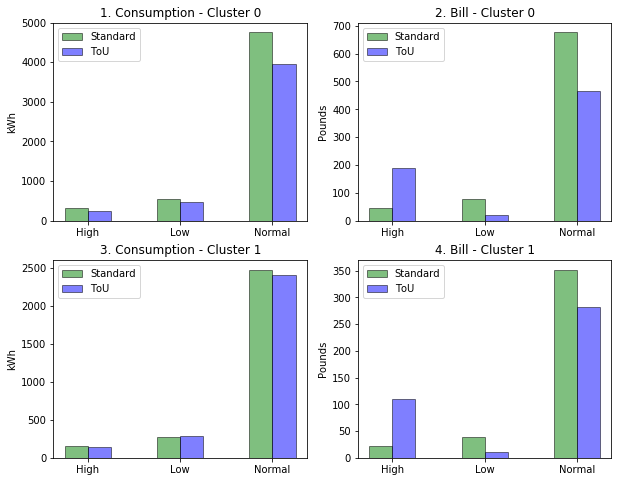

In [74]:
# visualise metrics from different clusters and signals
width = 0.25
fig, ax = plt.subplots(2, 2, figsize = (10, 8))
plot_count = 0
for i, cl in enumerate(tb['Cluster'].unique()):
    for j, mt in enumerate(tb['Metric'].unique()):
            # filter clusters and metric
            t_tou = tou['Value'].loc[(tou['Cluster'] == cl) & (tou['Metric'] == mt)]
            t_std = std['Value'].loc[(std['Cluster'] == cl) & (std['Metric'] == mt)]
            
            # plot bars
            ax[i,j].bar(X, t_std, width, color = 'green', alpha = 0.5, edgecolor = 'black')
            ax[i,j].bar(X+width, t_tou, width, color = 'blue', alpha = 0.5, edgecolor = 'black')
            
            # set xlabels
            ax[i,j].set_xticks(X+width/2)
            ax[i,j].set_xticklabels(list(x_dict.keys()))
            
            # Set the y axis label
            ax[i,j].set_ylabel(mt)
            # Set the chart's title
            title = fig_index[plot_count]+' '+desc_metric(mt) +' - '+  'Cluster '+str(cl)
            ax[i,j].set_title(title)

            ax[i,j].legend(['Standard', 'ToU'], loc='upper left') 
            plot_count = plot_count+1
plt.savefig(fig_path+'Consumptions and bills.png') 
plt.show()